In [1]:
import os
# os.chdir('models/fast_rcnn/')
import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from models.fast_rcnn.dataset import WaymoDataset, Resizer, Normalizer
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from models.efficientdet.src.config import COCO_CLASSES, colors
import os
import argparse
import torch
import cv2
import shutil
import tensorflow.compat.v1 as tf
import pickle
%matplotlib inline
from matplotlib import pyplot as plt

wd = WaymoDataset(
        cameras=['FRONT'], scope='validation',
        transform=transforms.Compose([Normalizer(), Resizer()]),
        mod='fast_rcnn')

model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
num_classes = wd.num_classes()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load('models/fast_rcnn/trained_models/fasterrcnn_resnet50_waymo.pth'))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

waymo_labels = ['vehicle', 'pedestrian', 'sign', 'cyclist']


/home/project_x/data/validation/FRONT_with_objects.pickle


In [ ]:
dat = [wd[0][0]]

In [ ]:
wd[0][1]['scale']

In [ ]:
model.eval()
out = model(dat)

In [13]:
# old_fc7 = model.roi_heads.box_head.fc7.weight

In [ ]:
new_fc7 = model.roi_heads.box_head.fc7.weight

In [2]:
# helper functions
def load_image(byte_img):
    img = tf.image.decode_jpeg(byte_img).numpy()
    return img

def load_pickle(fpath):
    with open(fpath, "rb") as f:
        return pickle.load(f)

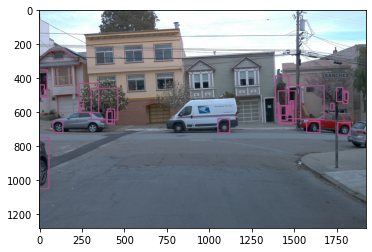

In [3]:
dataset = wd
waymo_labels = ['vehicle', 'pedestrian', 'sign', 'cyclist']
model.eval()
for index in range(2,3):
    data = dataset[index]
    images = [data[0]]
    scale = data[1]['scale']

    with torch.no_grad():
        output = model(images)
        scores, labels, boxes = output[0]['scores'], output[0]['labels'], output[0]['boxes']
        boxes /= scale
    if boxes.shape[0] > 0:
        output_image = load_image(load_pickle(data[1]['image_id'])['image'])
        
        for box_id in range(boxes.shape[0]):
            pred_prob = float(scores[box_id])
            if pred_prob < 0.05:
                break
            pred_label = int(labels[box_id])
            xmin, ymin, xmax, ymax = boxes[box_id, :]
            color = colors[pred_label]
            cv2.rectangle(output_image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 5)
#             text_size = cv2.getTextSize(waymo_labels[pred_label] + ' : %.2f' % pred_prob, cv2.FONT_HERSHEY_PLAIN, 2, 1)[0]

#             cv2.rectangle(output_image, (xmin, ymin), (xmin + text_size[0] +100, ymin + text_size[1] - 100), colors[pred_label+1], -1)
#             cv2.putText(
#                 output_image, waymo_labels[pred_label] + ' : %.2f' % pred_prob,
#                 (xmin, ymin + text_size[1] - 40), cv2.FONT_HERSHEY_PLAIN, 5,
#                 (255, 255, 255), 3)

        plt.imshow( output_image)
        plt.show()


In [ ]:
data[1]

In [ ]:
# ANNOTATIONS FROM DATASET OBJECT
output_image = load_image(load_pickle(data[1]['image_id'])['image'])
labels = data[1]

for box_id in range(labels['boxes'].shape[0]):
    label = labels['boxes'][box_id]
    pred_label = int(labels['labels'][box_id])
    scaled = label/labels['scale']
    xy1=(scaled[0],scaled[1])
    xy2=(scaled[2],scaled[3])
    
    xmin, ymin = (int(i) for i in xy1)
    xmax, ymax = (int(i) for i in xy2)
    color = colors[pred_label]
    cv2.rectangle(output_image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 5)
    text_size = cv2.getTextSize(COCO_CLASSES[pred_label] + ' : %.2f' % pred_prob, cv2.FONT_HERSHEY_PLAIN, 2, 1)[0]
plt.imshow( output_image)


In [ ]:
os.chdir('/home/project_x/evaluation/waymo-od/waymo_open_dataset')

In [ ]:
# wd[5]['raw']['context']
debox = lambda x: [x.center_x, x.center_y, x.width, x.length]
frame = wd[5]['raw']
labels = frame['labels'].labels
num_boxes = len(labels)
pred_frame_id = [
    frame['context']['name']+ frame[
        'context'][
        'time_frame_idx'] for _ in range(num_boxes)
                ]
pred_bbox = [debox(i.box) for i in labels]
pred_type = [i.type for i in labels]
pred_score = [1 for i in range(num_boxes)]

In [ ]:
[i for i, s in enumerate(wd.filepaths) if 'blob_130' in s] # 0,105,167

In [ ]:
import torch
from waymo_open_dataset.protos import metrics_pb2
from waymo_open_dataset import label_pb2,dataset_pb2
import concurrent.futures as concurr

# ['vehicle', 'pedestrian', 'sign', 'cyclist']
# Could have included things like boat, train, airplane (vehicles?)
class_mapper = {
    0: 2, # person
    1:4, # in COCO it's bicycle not cyclist...
    2:1, # car
    3:1, # motorcycle
    5:1, # bus
    7:1, # truck
    11:3 # stop sign
}
score_threshold = 0.3 
def get_preds(sample, model):
    with torch.no_grad():
        scores, annot, boxes = model(sample['img'].permute(2, 0, 1).float().unsqueeze(dim=0))
        boxes /= sample['scale']
    return scores, annot, boxes
def convert_to_waymo_boxes(boxes):
    tb = boxes.T
    length = tb[2]-tb[0]
    width = tb[3]-tb[1]
    tb[0] = tb[2]-length # center x
    tb[1] = tb[3]-width # center y
    tb[2] = length
    tb[3] = width
    res = tb.T
    return res
def gt_map(o, data):
    box = label_pb2.Label.Box()
    box.center_x = data.box.center_x
    box.center_y = data.box.center_y
    box.length = data.box.length
    box.width = data.box.width

    o.object.box.CopyFrom(box)
    o.score = 1
    # Use correct type.
    o.object.type = data.type
def pred_map(o, data):
    s, c, b = data
    box = label_pb2.Label.Box()
    box.center_x = b[0]
    box.center_y = b[1]
    box.length = b[2]
    box.width = b[3]
    o.object.box.CopyFrom(box)
    o.score = s
    # Use correct type.
    o.object.type = class_mapper[c.item()]
    o.object.type = c.item()+1

def filter_preds(data):
    scores, classes, boxes = data
    valid_idxs = []
    for c,cls in enumerate(classes):
#         if (cls in [0,1,2,3, 5,7,11])&
        if (scores[c]>score_threshold):
            valid_idxs.append(c)
    valid_idxs = torch.tensor(valid_idxs).long()
    scores = scores.index_select(0, valid_idxs)
    classes = classes.index_select(0, valid_idxs)
    boxes = boxes.index_select(0, valid_idxs)
    return (scores, classes, boxes)
def process_frame_objects(objects, data, name, ts, cam, scope):
    if scope=='preds':
        data = filter_preds(data)
        num_objects = len(data[0])
        boxes = convert_to_waymo_boxes(data[2])
    else:
        num_objects = len(data)
    for c in range(num_objects):
        o = metrics_pb2.Object()
        o.context_name = name
        o.frame_timestamp_micros = ts
        o.camera_name = cam = cam
        if scope=='preds':
            data_i = (data[0][c], data[1][c], boxes[c]) # scores, classes, boxes
            pred_map(o, data_i)
        else:
            gt_map(o, data[c])
        objects.objects.append(o)

        
def single_frame_thread(item, model, ):
    preds = get_preds(item, model)
    ctx = item['raw']['context']
    cam = getattr(dataset_pb2.CameraName, dataset.get_cam_type(c))
    # Populate preds
    process_frame_objects(pred_objects, preds, ctx['name'],
                          ctx['timestamp'], cam, 'preds')
    process_frame_objects(gt_objects, item['raw']['labels'].labels, ctx['name'],
                          ctx['timestamp'], cam, 'gt')     
def create_pd_file(dataset, model): # preds or gt
    """Creates a prediction objects file."""
    gt_objects = metrics_pb2.Objects()
    pred_objects = metrics_pb2.Objects()
    

    for c, item in enumerate(dataset):
        preds = get_preds(item, model)
        ctx = item['raw']['context']
        cam = getattr(dataset_pb2.CameraName, dataset.get_cam_type(c))
        # Populate preds
        process_frame_objects(pred_objects, preds, ctx['name'],
                              ctx['timestamp'], cam, 'preds')
        process_frame_objects(gt_objects, item['raw']['labels'].labels, ctx['name'],
                              ctx['timestamp'], cam, 'gt')        
        if c%500==0:
            print(f'Processed {c} frames out of {len(dataset)}')
        if c==1000:
            break
            
    # Write objects to a file.
    f = open('/home/project_x/evaluation/results/preds.bin', 'wb')
    f.write(pred_objects.SerializeToString())
    f.close()
    f = open('/home/project_x/evaluation/results/gt.bin', 'wb')
    f.write(gt_objects.SerializeToString())
    f.close()
    print("Done compiling results")
create_pd_file(wd, model)

In [ ]:
import concurrent.futures as concurr
# def threader(obj, value):
#     obj.append(value)

# lst = []
# thread_iterable = [(lst, i) for i in range(20)]
# with concurr.ThreadPoolExecutor(max_workers = 2) as executor:

#     results = executor.map(lambda args: threader(*args), thread_iterable)
#     for r in results:
#         print(f'\n ran {r}')
def threader(value):
    return value, value/2

lst = []
thread_iterable = list(range(20))
with concurr.ProcessPoolExecutor(max_workers = 2) as executor:

    results = executor.map(threader, thread_iterable)
    for r in results:
        for i in r:
            lst.append(i)
lst


In [ ]:
x = """"""
y = [float(i.split(': ')[1]) for i in x.split('\n') if ': ' in i]
plt.plot(y)

In [ ]:
from waymo_open_dataset.protos import metrics_pb2
from waymo_open_dataset import label_pb2,dataset_pb2
label_pb2.Label.TYPE_SIGN